In [11]:
import torch
import torchvision
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim as optim

In [12]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                               transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

In [13]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 konfiguracja
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # self.pool1 = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        # self.pool2 = nn.MaxPool2d(2)
        # self.fc1 = nn.Linear(64*6*6, 600)
        # self.fc2 = nn.Linear(600, 120)
        # self.fc3 = nn.Linear(120, 10)

        # 2 konfiguracja
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128*6*6, 300)
        self.fc2 = nn.Linear(300, 60)
        self.fc3 = nn.Linear(60, 10)

        # 3 konfiguracja
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # self.pool1 = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)
        # self.pool2 = nn.MaxPool2d(2)
        # self.fc1 = nn.Linear(128*6*6, 300)
        # self.fc2 = nn.Linear(300, 60)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # ponizsza linijka zakomentowana tylko dla 3. konfiguracji
        x = self.fc3(x)
        return x


net = Net()

In [14]:
num_epochs = 2
count = 0
loss_list = []
accuracy_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()
model.to(device)

error = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        outputs = model(train)
        loss = error(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
    
        if not (count % 50):
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
        
        if not (count % 100):
            print("Iteration: {}, Loss: {}".format(count, loss.data))

Iteration: 100, Loss: 2.287357807159424
Iteration: 200, Loss: 2.2707455158233643
Iteration: 300, Loss: 2.222261905670166
Iteration: 400, Loss: 2.1200735569000244
Iteration: 500, Loss: 1.5588726997375488
Iteration: 600, Loss: 1.031233310699463
Iteration: 700, Loss: 0.9652994275093079
Iteration: 800, Loss: 1.0803581476211548
Iteration: 900, Loss: 0.7490729689598083
Iteration: 1000, Loss: 0.7750347256660461
Iteration: 1100, Loss: 0.7250974774360657
Iteration: 1200, Loss: 0.6885396838188171


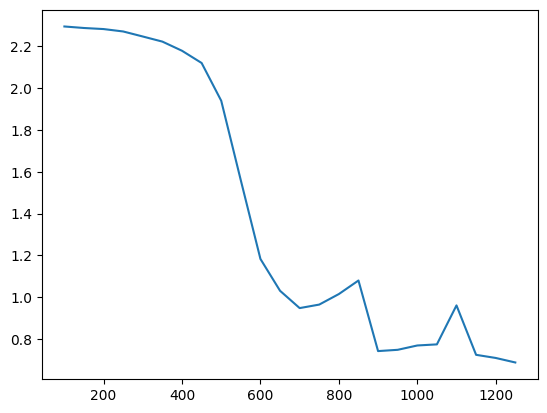

In [15]:
plt.plot([i*50+100 for i in range(len(loss_list))], loss_list)
plt.show()

In [16]:
from itertools import chain
from sklearn.metrics import confusion_matrix

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))


print(confusion_matrix(labels_l, predictions_l))

[[13097  1091   587  1368  6974    82   639     2   157     3]
 [  277 19635   166  1100  2736     0    67     0    19     0]
 [  374   229  9334   218 11948    15  1426     0   452     4]
 [ 1805  8258   158  7954  5239     5   500     0    81     0]
 [  404   521  5096   907 16134    33   597     0   307     1]
 [    0   282    10    27  4999 11164     0  3913    98  3507]
 [ 3980   591  5412   952 10665    30  1746     1   619     4]
 [    0    76     0     0  5270  1901     0 14087     7  2659]
 [   23   271   953   187  8480   280   206   131 12978   491]
 [    0    11     9    11  4889   334     0   851    67 17828]]


In [17]:
for i in range(len(predictions_l)):
  image, label = next(iter(test_loader))
  if predictions_l[i] != label[i].numpy():
    print(label[i].numpy(), predictions_l[i])
    break  

9 4
